In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
nr = 100
nt = 150

t = np.linspace(-0.1,2.5,nt)        # time axis, µs
r = np.linspace(2,8,nr)      # distance axis, ns

r0 = 4 
fwhm = 0.4 # parameters for three-Gaussian model
Ptrue = dive.dd_gauss(r,r0,fwhm)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
Ptrue = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,integralop=False)    # kernel matrix
sigma = 0.01

S0 = K@Ptrue
sigma = 0.05*max(S0)
S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

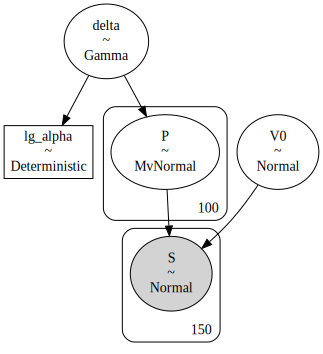

In [19]:
a0 = 0.01
b0 = 1e-6

# tau = 1/(sigma**2)
# alpha = comes from regularization solution
# delta_init = alpha^2*tau
# P_init = randP(delta_init,tauKTK,tauKtS,LtL,nr)

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

# These parameters are only used for the definition of P0 as a pymc3 variable
Pmap = Ptrue

with pm.Model() as model:
    # Noise
    # sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P = pm.MvNormal("P", mu=Pmap, chol = C_L, shape = nr)    
    # P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    V0 = pm.Normal('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = V0*Smodel, sigma = sigma, observed = S)
    # pm.Normal('S',mu = Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [20]:
trace = pm.load_trace('../scripts/randP/edwards_more_noise.trace', model = model)

In [21]:
VarNames = trace.varnames
display(VarNames)

['delta_log__', 'P', 'V0', 'delta', 'lg_alpha']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V₀,1.004,0.017,0.972,1.036,0.000,0.000,18898.0,21469.0,1.0
δ,741.168,195.200,398.568,1103.767,2.197,1.553,7602.0,12358.0,1.0
lg(α),1.344,0.057,1.238,1.451,0.001,0.000,7602.0,12358.0,1.0


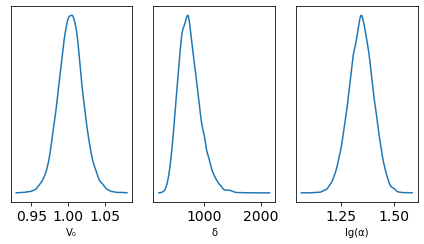

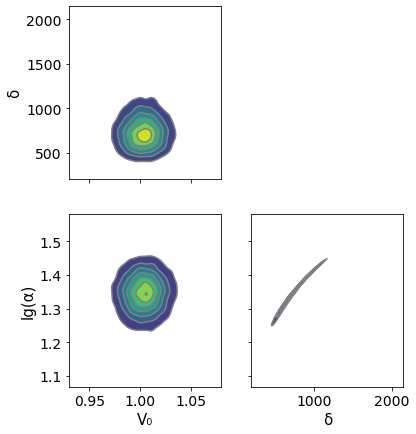

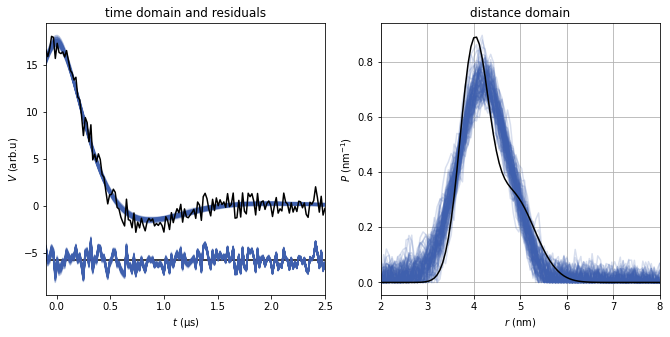

In [23]:
dive.summary(trace, model, S, t, r, Ptrue = Pmap)